In [2]:
%matplotlib inline

# Import packages and functions
import modelbase
import numpy as np
import pandas as pd
import os
import importlib
import sys
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm, CenteredNorm, SymLogNorm, Normalize
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import find_peaks, savgol_filter
from scipy.stats import iqr
from scipy.integrate import simpson
from scipy.optimize import minimize

from modelbase.ode import Model, Simulator, mca
from modelbase.ode import ratelaws as rl
from modelbase.ode import ratefunctions as rf

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from sympy import Matrix, lambdify, linsolve, symbols
from warnings import warn
from os import listdir
from os.path import join

# Helper functions
sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model
from module_update_phycobilisomes import add_OCP

from functions_custom_steady_state_simulator import simulate_to_steady_state_custom, _find_steady_state, get_response_coefficients, get_response_coefficients_array, get_response_coefficients_df, calculate_ss_Q_red, get_steadystate_y0

In [5]:
m, y0 = get_model()
m=fnc.add_exchange(m)
s = Simulator(m)
s.initialise(y0)

s,t,y = simulate_to_steady_state_custom(s,         simulation_kwargs={
        "t_end": 1e6,
        "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
        "verbose": True,
    },
    rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


In [13]:
# Adapt a model so that no compounds accumulate or drain
# Define a dictionary with all compounds that should be held constant
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

# Define the MCA model by adding a flux keeping 3PGA constant
m_MCA,y0 = get_model(check_consistency=False, verbose=False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

m_MCA.update_parameter("pfd", lip.light_spectra("solar", 400))

simulation_kwargs={
    "t_end": 1e6,
    "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
    "verbose": True,
}
rel_norm=True
parameters = ["PSItot"]

_ccc, _fcc = get_response_coefficients_df(
    m_MCA,
    parameters,
    y=y0,
    displacement=0.01,
    tolerance=None,
    disable_tqdm=True, 
    multiprocessing=False,
    rel_norm=rel_norm,
    simulation_kwargs=simulation_kwargs,
    **fnc.simulator_kwargs["loose"]
)

steady state not reached
CBBa   -1.323079e-09
PSII    5.055818e-08
OCP     5.199082e-14
dtype: float64


(<Figure size 1850x1050 with 4 Axes>,
 array([[<AxesSubplot: title={'center': 'ETC compounds'}, xlabel='time [s]', ylabel='concentration [mmol mol(Chl)$^{-1}$]'>,
         <AxesSubplot: title={'center': 'O$_2$ and CO$_2$'}, xlabel='time [s]', ylabel='concentration [mmol mol(Chl)$^{-1}$]'>],
        [<AxesSubplot: title={'center': 'pH of lumen and cytoplasm'}, xlabel='time [s]', ylabel='pH'>,
         <AxesSubplot: title={'center': 'CBB & PR compounds'}, xlabel='time [s]', ylabel='concentration [mmol mol(Chl)$^{-1}$]'>]],
       dtype=object))

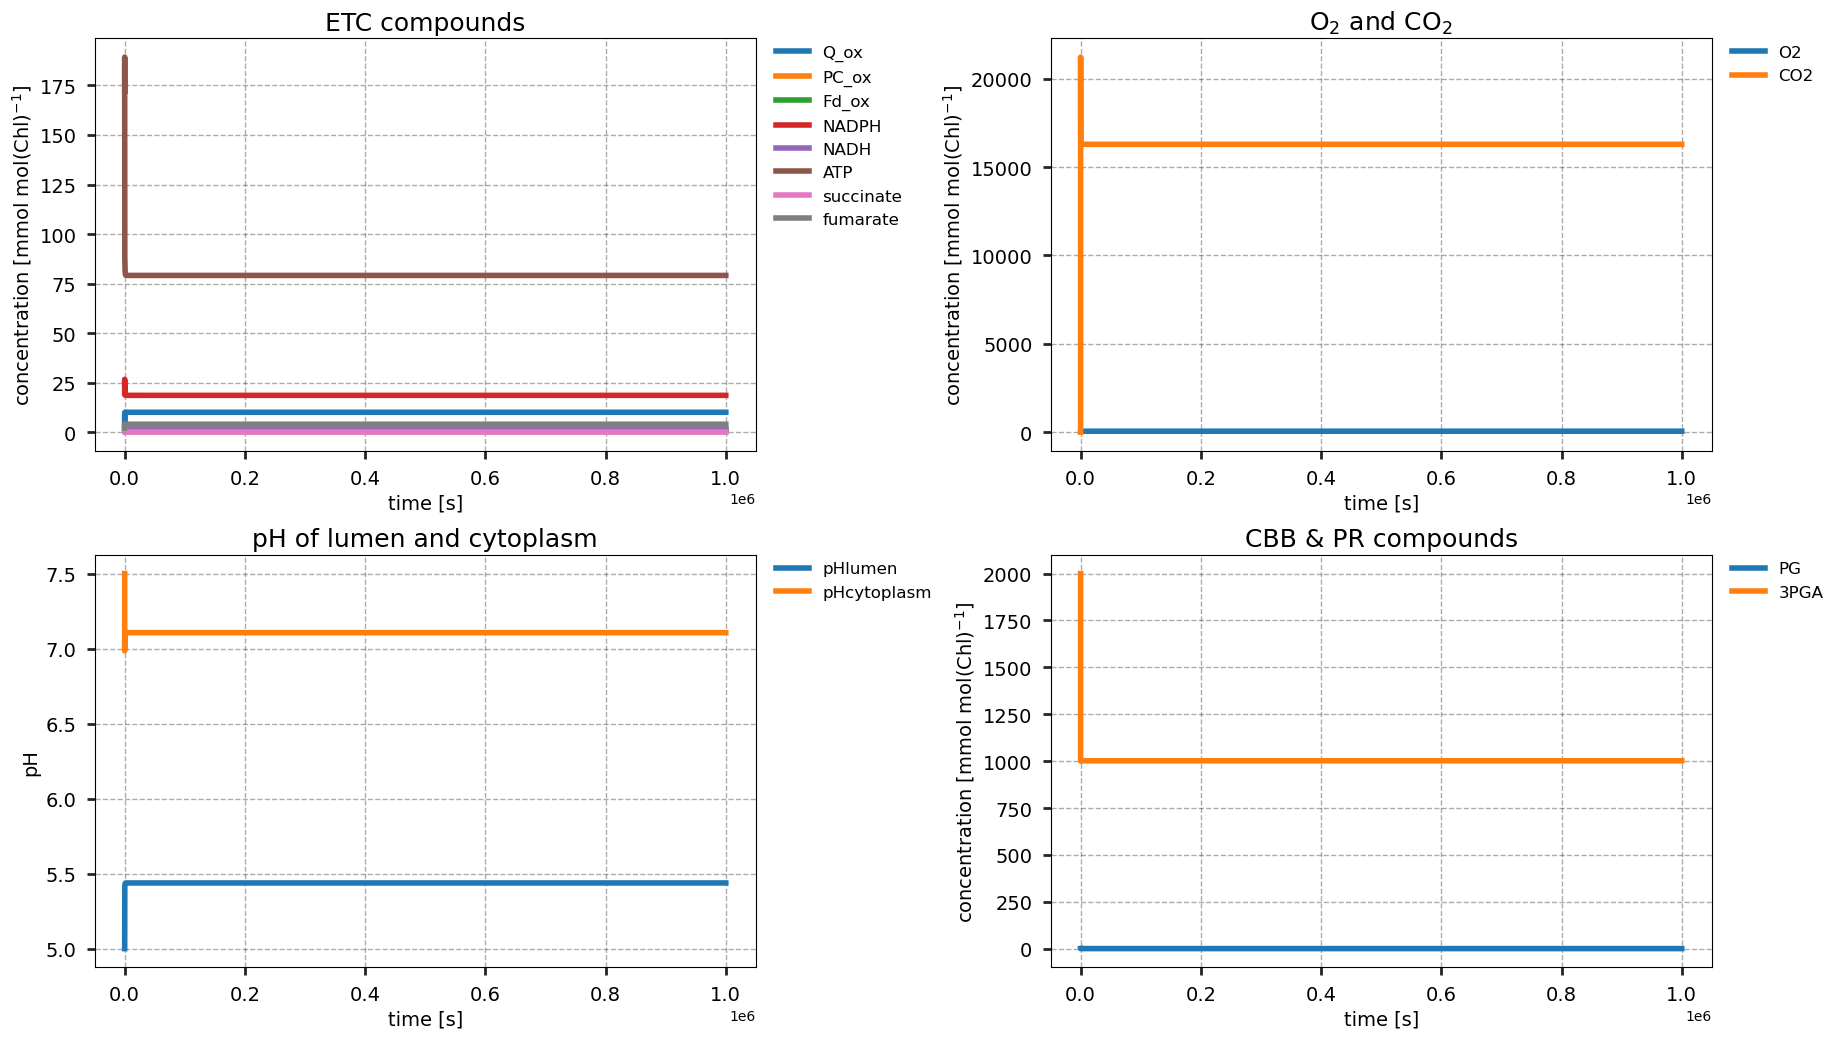

In [14]:
s = Simulator(m_MCA)
s.initialise(y0)
s.simulate(1e6)
fnc.plot_overview(s)

In [126]:
s = Simulator(m_MCA)
s.initialise(y0)
s.simulate(1e6)

# Calculate the relative change between integration points
res = s.get_full_results_df()
rel = (res.apply(np.diff)) / (res.iloc[1:,:].reset_index().drop("index",axis=1))
rel.index = res.index[1:]

In [134]:
rel.abs().min(axis=1)

1.590718e-09    0.0
3.181436e-09    0.0
4.772155e-09    0.0
8.220054e-09    0.0
1.166795e-08    0.0
               ... 
3.541801e+05    0.0
4.321986e+05    0.0
5.102171e+05    0.0
5.882356e+05    0.0
1.000000e+06    0.0
Length: 1733, dtype: float64

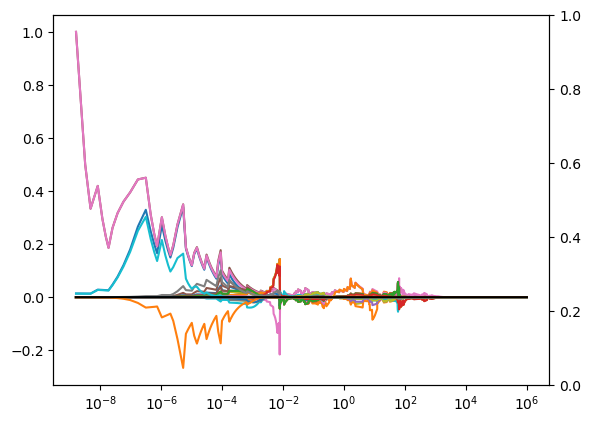

In [136]:
fig, ax  = plt.subplots()
ax.plot(rel)

ax2 = ax.twinx()

for do_subset in [True, False]:
    if do_subset:
        diff = 
ax.plot(rel.abs().min(axis=1), c="k")

ax.set_xscale("log")

(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

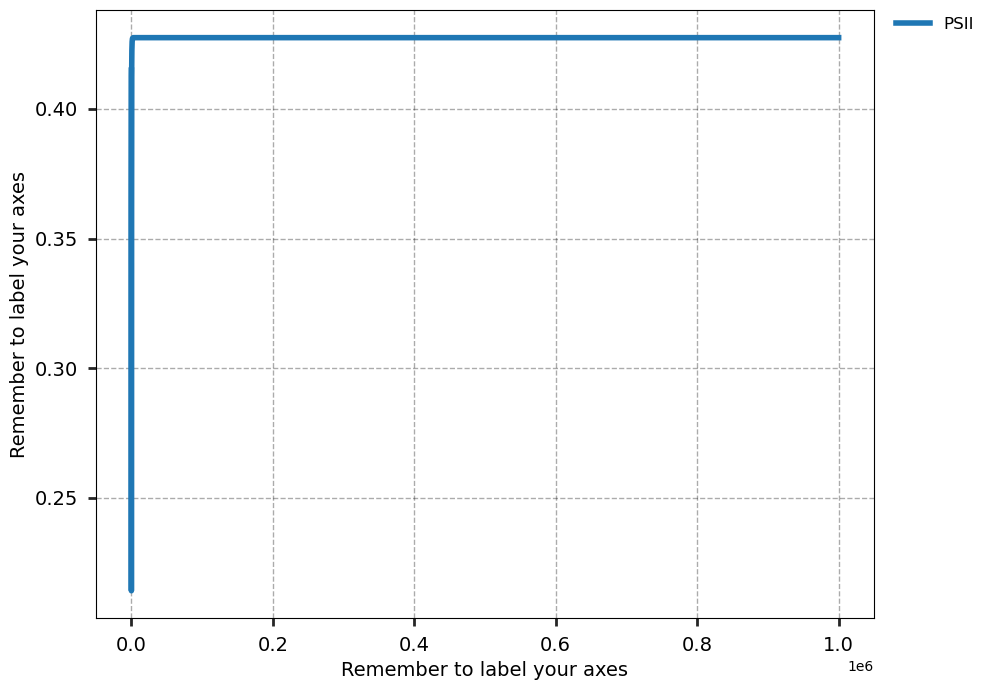

In [15]:
fig, ax = plt.subplots
ax = s.plot_selection("PSII")

In [ ]:


s = Simulator(m)
s.initialise(y0)
s.simulate()